# Random Forest

- If we have B(B numbers of sample mean) IID random variables, variance of the sum/sample mean is

$$
var(\bar{\theta_{B}}) = \frac{1}{B}\sigma^2
$$

- If we have B ID(identically distributed, not independent), then variance of the sum is 

$$
var(\bar{\theta_{B}}) = \frac{1-\varrho}{B}\sigma^2+ \varrho\sigma^2
$$

- Random forest tries to reduce this correlation $\varrho$
- i.e. build a set of trees decorrelated from each other
- Recall bagging: by having many trees of arbitrary depth, we can ensure they overfit(0 bias) to their own training samples(and thus will probably be very different from each other)
- why? we want $\varrho$ -> 0
- is there anything else we can do to ensure decorrelation(other than just letting each tree overfit?)

- We can achieve low bias easily with trees simply by adding more nodes
- suppose each tree in ensemble has low bias
- each tree has same expected value,then expected value of sum of trees also has the same expected value
- so the ensemble also has low bias


- How does random forest decorrelate the trees?
- before: we randomly chose which samples to train on
- Now: we can also choose which features to train on
- how many do we choose? d<< D , matrix is N(input rows) x D(features)
$$
\text{classification} = d = floor(\sqrt{D})\\
\text{regression} = d = floor(D/3)\\
$$

- recommendations by inventors
- classification : as low as 1
- regression : as low as 5
- best: what works for your specific dataset

## Random forest Training

```python
for b = 1,...,B:
    Xb,Yb = sample_with_replacement(X,Y)
    model = DecisionTree()
    while not at terminal node and not reached max_depth:
        select d features randomly
        choose best split from the d features(i.e. max.information gain)
        add split to model
    models.append(model)
    

```

- just like bagging, we need to get bootstrap sample
- sometimes Random Forest is called feature bagging
- these are not ensembles of vanilla decision tree
- we've changed how they make splits
- so you can't build a random forest using built-in decision tree class


- What if many features are just noise?
- what if random forest chooses only noise to split on?
- If we have 3 relevant + 100 irrelevant inputs, probability of choosing a relevant feature for d = floor(sqrt(103)) = 10 is 
- If we had 6 relevant variables this would go up to 46%
- we will later learn an algorithm that doesn't have this problem

- Big advantage: requires very little tuning
- can let all trees go to arbitrary depth without incurring much penalty
- perform well are fast
- when people come to deep learning in searh of an API, I just recommend random forest instead
- neural networks have many more hyperparameters, are sensitive to those choices


# Random Forest Regressor

## random forest regression
- we will apply to real data
- no more 2-d plots

- housing price dataset

- use Sklearn random forest
- all features are numerical except for one binary(already 0/1)
- no feature engineering or feature selection 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from future.utils import iteritems

```txt
Attribute Information:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per $10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    % lower status of the population
    14. MEDV     Median value of owner-occupied homes in $1000's
```

In [2]:
NUMERICAL_COLS = [
  'crim', # numerical
  'zn', # numerical
  'nonretail', # numerical
  'nox', # numerical
  'rooms', # numerical
  'age', # numerical
  'dis', # numerical
  'rad', # numerical
  'tax', # numerical
  'ptratio', # numerical
  'b', # numerical
  'lstat', # numerical
]

NO_TRANSFORM = ['river']



```python
StandardScaler : normalize the real data
```

In [3]:
# transforms data from dataframe to numerical matrix
# we want to use the scales found in training when transforming the test set
# so only call fit() once
# call transform() for any subsequent data
class DataTransformer:
  def fit(self, df):
    self.scalers = {}
    for col in NUMERICAL_COLS:
      scaler = StandardScaler()
      scaler.fit(df[col].values.reshape(-1, 1))
      self.scalers[col] = scaler

  def transform(self, df):
    N, _ = df.shape
    D = len(NUMERICAL_COLS) + len(NO_TRANSFORM)
    X = np.zeros((N, D))
    i = 0
    for col, scaler in iteritems(self.scalers):
      X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
      i += 1
    for col in NO_TRANSFORM:
      X[:,i] = df[col]
      i += 1
    return X

  def fit_transform(self, df):
    self.fit(df)
    return self.transform(df)



In [4]:
def get_data():
  # regex allows arbitrary number of spaces in separator
  df = pd.read_csv('./data/housing.data', header=None, sep=r"\s*", engine='python')
  df.columns = [
    'crim', # numerical
    'zn', # numerical
    'nonretail', # numerical
    'river', # binary
    'nox', # numerical
    'rooms', # numerical
    'age', # numerical
    'dis', # numerical
    'rad', # numerical
    'tax', # numerical
    'ptratio', # numerical
    'b', # numerical
    'lstat', # numerical
    'medv', # numerical -- this is the target
  ]
  print("df.shape {}".format(df.shape))
  # transform the data
  transformer = DataTransformer()

  # shuffle the data
  N = len(df)
  train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
  test_idx = [i for i in range(N) if i not in train_idx]
  df_train = df.loc[train_idx]
  df_test = df.loc[test_idx]

  print("df_train.shape {}".format(df_train.shape))
  Xtrain = transformer.fit_transform(df_train)
  Ytrain = np.log(df_train['medv'].values)
  Xtest = transformer.transform(df_test)
  Ytest = np.log(df_test['medv'].values)
  return Xtrain, Ytrain, Xtest, Ytest


In [5]:

Xtrain, Ytrain, Xtest, Ytest = get_data()


df.shape (506, 14)
df_train.shape (354, 14)


/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data

In [6]:
Xtrain.shape,Ytrain.shape

((354, 13), (354,))

In [9]:
Ytrain

array([3.21084365, 3.314186  , 2.83907846, 2.99071973, 2.96527307,
       3.13983262, 3.74478709, 3.04452244, 2.95491028, 3.61630876,
       1.94591015, 2.92852352, 2.77881927, 3.21887582, 3.09104245,
       2.17475172, 3.06805294, 3.22286785, 3.91202301, 3.15700042,
       2.11625551, 2.69462718, 3.16547505, 2.97552957, 2.09186406,
       2.77881927, 3.01062089, 3.13983262, 3.17805383, 3.35689712,
       3.56104608, 2.62466859, 3.02529108, 3.6558396 , 2.42480273,
       3.06339092, 1.97408103, 2.74727091, 3.11351531, 3.20680324,
       2.87919846, 3.91202301, 2.85647021, 3.03974916, 3.91202301,
       3.50254988, 2.66025954, 3.10009229, 3.8286414 , 3.05400118,
       3.27336401, 3.09557761, 3.06339092, 2.83907846, 3.35340672,
       3.19867312, 2.97552957, 3.13549422, 3.54673969, 3.29953373,
       2.8507065 , 3.01062089, 3.40452517, 2.68102153, 3.02042489,
       3.09104245, 2.92316158, 3.13983262, 3.07731226, 3.35689712,
       2.61006979, 3.17387846, 3.07731226, 3.21887582, 2.14006

[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)  

```python
# A random forest regressor.

# A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).


```

- n_estimators : integer, optional (default=10)

    The number of trees in the forest.

    Changed in version 0.20: The default value of n_estimators will change from 10 in version 0.20 to 100 in version 0.22.
    
- criterion : string, optional (default=”mse”)

    The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error.

    New in version 0.18: Mean Absolute Error (MAE) criterion.
- max_depth : integer or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split : int, float, optional (default=2)

    The minimum number of samples required to split an internal node:

    If int, then consider min_samples_split as the minimum number.
    If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

    


In [17]:
model = RandomForestRegressor(n_estimators=100) # try 10, 20, 50, 100, 200
model.fit(Xtrain, Ytrain)
predictions = model.predict(Xtest)


ymin: 2.0 ymax: 4.0


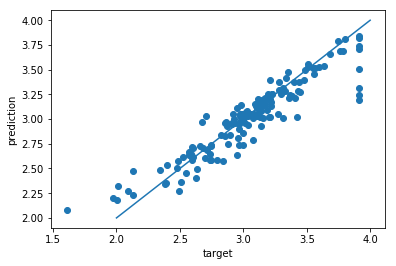

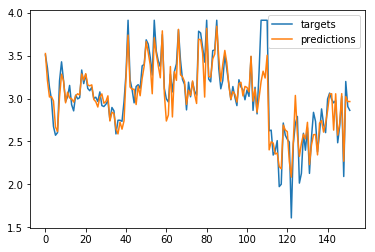

In [18]:
%matplotlib inline

# plot predictions vs targets
plt.scatter(Ytest, predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(Ytest), min(predictions) ) )
ymax = np.ceil( max( max(Ytest), max(predictions) ) )
print("ymin:", ymin, "ymax:", ymax)
r = range(int(ymin), int(ymax) + 1)
plt.plot(r, r)
plt.show()

plt.plot(Ytest, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()


[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)  

In [19]:
# do a quick baseline test
baseline = LinearRegression()
single_tree = DecisionTreeRegressor()
print("CV single tree:", cross_val_score(single_tree, Xtrain, Ytrain).mean())
print("CV baseline:", cross_val_score(baseline, Xtrain, Ytrain).mean())
print("CV forest:", cross_val_score(model, Xtrain, Ytrain).mean())

# test score
single_tree.fit(Xtrain, Ytrain)
baseline.fit(Xtrain, Ytrain)
print("test score single tree:", single_tree.score(Xtest, Ytest))
print("test score baseline:", baseline.score(Xtest, Ytest))
print("test score forest:", model.score(Xtest, Ytest))



/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CV single tree: 0.6359539399041506
CV baseline: 0.7075110620648992


/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CV forest: 0.7891930219300543
test score single tree: 0.5739146081090266
test score baseline: 0.7928374669775282
test score forest: 0.8546568914082502


## Random Forest Classification In Code

In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


In [36]:
NUMERICAL_COLS = ()
CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

# transforms data from dataframe to numerical matrix
# one-hot encodes categories and normalizes numerical columns
# we want to use the scales found in training when transforming the test set
# so only call fit() once
# call transform() for any subsequent data
class DataTransformer:
  def fit(self, df):
    self.labelEncoders = {}
    self.scalers = {}
    for col in NUMERICAL_COLS:
      scaler = StandardScaler()
      scaler.fit(df[col].reshape(-1, 1))
      self.scalers[col] = scaler

    for col in CATEGORICAL_COLS:
      encoder = LabelEncoder()
      # in case the train set does not have 'missing' value but test set does
      values = df[col].tolist()
      values.append('missing')
      encoder.fit(values)
      self.labelEncoders[col] = encoder

    # find dimensionality
    self.D = len(NUMERICAL_COLS)
    for col, encoder in iteritems(self.labelEncoders):
      print("encoder.classes_ {} len:{}".format(encoder.classes_,len(encoder.classes_)))
      self.D += len(encoder.classes_)
    print("dimensionality:", self.D)

  def transform(self, df):
    N, _ = df.shape
    X = np.zeros((N, self.D))
    i = 0
    for col, scaler in iteritems(self.scalers):
      X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
      i += 1

    for col, encoder in iteritems(self.labelEncoders):
      # print "transforming col:", col
      K = len(encoder.classes_)
      X[np.arange(N), encoder.transform(df[col]) + i] = 1
      i += K
    return X

  def fit_transform(self, df):
    self.fit(df)
    return self.transform(df)


In [31]:

def replace_missing(df):
  # standard method of replacement for numerical columns is median
  for col in NUMERICAL_COLS:
    print("numerical col {}".format(col))
    if np.any(df[col].isnull()):
      med = np.median(df[ col ][ df[col].notnull() ])
      df.loc[ df[col].isnull(), col ] = med

  # set a special value = 'missing'
  for col in CATEGORICAL_COLS:
    print("CATEGORICAL_COLS col {}".format(col))
    if np.any(df[col].isnull()):
      print(col)
      df.loc[ df[col].isnull(), col ] = 'missing'



[Mushroom dataset](https://archive.ics.uci.edu/ml/datasets/Mushroom)

In [23]:

def get_data():
  df = pd.read_csv('./data/mushroom.data', header=None)

  # replace label column: e/p --> 0/1
  # e = edible = 0, p = poisonous = 1
  df[0] = df.apply(lambda row: 0 if row[0] == 'e' else 1, axis=1)

  # check if there is missing data
  replace_missing(df)

  # transform the data
  transformer = DataTransformer()

  X = transformer.fit_transform(df)
  Y = df[0].values
  return X, Y


In [27]:
df = pd.read_csv('./data/mushroom.data', header=None)
df.shape


(8124, 23)

In [30]:
df.head()
df[0] = df.apply(lambda row: 0 if row[0] == 'e' else 1, axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,0,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,0,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,1,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,0,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [37]:
X, Y = get_data()


CATEGORICAL_COLS col 1
CATEGORICAL_COLS col 2
CATEGORICAL_COLS col 3
CATEGORICAL_COLS col 4
CATEGORICAL_COLS col 5
CATEGORICAL_COLS col 6
CATEGORICAL_COLS col 7
CATEGORICAL_COLS col 8
CATEGORICAL_COLS col 9
CATEGORICAL_COLS col 10
CATEGORICAL_COLS col 11
CATEGORICAL_COLS col 12
CATEGORICAL_COLS col 13
CATEGORICAL_COLS col 14
CATEGORICAL_COLS col 15
CATEGORICAL_COLS col 16
CATEGORICAL_COLS col 17
CATEGORICAL_COLS col 18
CATEGORICAL_COLS col 19
CATEGORICAL_COLS col 20
CATEGORICAL_COLS col 21
CATEGORICAL_COLS col 22
encoder.classes_ ['b' 'c' 'f' 'k' 'missing' 's' 'x'] len:7
encoder.classes_ ['f' 'g' 'missing' 's' 'y'] len:5
encoder.classes_ ['b' 'c' 'e' 'g' 'missing' 'n' 'p' 'r' 'u' 'w' 'y'] len:11
encoder.classes_ ['f' 'missing' 't'] len:3
encoder.classes_ ['a' 'c' 'f' 'l' 'm' 'missing' 'n' 'p' 's' 'y'] len:10
encoder.classes_ ['a' 'f' 'missing'] len:3
encoder.classes_ ['c' 'missing' 'w'] len:3
encoder.classes_ ['b' 'missing' 'n'] len:3
encoder.classes_ ['b' 'e' 'g' 'h' 'k' 'missing' 'n'

In [25]:
X.shape,Y.shape

((8124, 139), (8124,))

In [33]:
X[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.])

In [26]:
# do a quick baseline test
baseline = LogisticRegression()
print("CV baseline:", cross_val_score(baseline, X, Y, cv=8).mean())

# single tree
tree = DecisionTreeClassifier()
print("CV one tree:", cross_val_score(tree, X, Y, cv=8).mean())

model = RandomForestClassifier(n_estimators=20) # try 10, 20, 50, 100, 200
print("CV forest:", cross_val_score(model, X, Y, cv=8).mean())


/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/home9second/.virtualenvs/deeplearning/lib/python3.5/si

CV baseline: 0.9274806301152012
CV one tree: 0.9189967902719056
CV forest: 0.9467059074512238


# Random Forest & Bagging Trees

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, RandomForestClassifier, BaggingClassifier



In [13]:

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

class BaggedTreeRegressor:
  def __init__(self, n_estimators, max_depth=None):
    self.B = n_estimators
    self.max_depth = max_depth

  def fit(self, X, Y):
    N = len(X)
    self.models = []
    for b in range(self.B):
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      model = DecisionTreeRegressor(max_depth=self.max_depth)
      model.fit(Xb, Yb)
      self.models.append(model)

  def predict(self, X):
    predictions = np.zeros(len(X))
    for model in self.models:
      predictions += model.predict(X)
    return predictions / self.B

  def score(self, X, Y):
    d1 = Y - self.predict(X)
    d2 = Y - Y.mean()
    return 1 - d1.dot(d1) / d2.dot(d2)



In [3]:
# make simple regression data
N = 15
D = 100
X = (np.random.random((N, D)) - 0.5)*10
Y = X.sum(axis=1)**2 + 0.5*np.random.randn(N)
Ntrain = N//2
Xtrain = X[:Ntrain]
Ytrain = Y[:Ntrain]
Xtest = X[Ntrain:]
Ytest = Y[Ntrain:]


In [9]:
Xtrain.shape,Ytrain.shape

((7, 100), (7,))

In [11]:
Ytrain

array([ 2.59983426e+03,  3.59412331e+03,  4.24266769e+01, -3.88995030e-01,
        1.17746870e+00,  1.11266881e+03,  1.91209048e+03])

In [14]:
T = 300
test_error_rf = np.empty(T)
test_error_bag = np.empty(T)
for num_trees in range(T):
  if num_trees == 0:
    test_error_rf[num_trees] = None
    test_error_bag[num_trees] = None
  else:
    rf = RandomForestRegressor(n_estimators=num_trees)
    # rf = RandomForestClassifier(n_estimators=num_trees)
    rf.fit(Xtrain, Ytrain)
    test_error_rf[num_trees] = rf.score(Xtest, Ytest)

    bg = BaggedTreeRegressor(n_estimators=num_trees)
    # bg = BaggedTreeClassifier(n_estimators=num_trees)
    bg.fit(Xtrain, Ytrain)
    test_error_bag[num_trees] = bg.score(Xtest, Ytest)

  if num_trees % 10 == 0:
    print("num_trees:", num_trees)


num_trees: 0
num_trees: 10
num_trees: 20
num_trees: 30
num_trees: 40
num_trees: 50
num_trees: 60
num_trees: 70
num_trees: 80
num_trees: 90
num_trees: 100
num_trees: 110
num_trees: 120
num_trees: 130
num_trees: 140
num_trees: 150
num_trees: 160
num_trees: 170
num_trees: 180
num_trees: 190
num_trees: 200
num_trees: 210
num_trees: 220
num_trees: 230
num_trees: 240
num_trees: 250
num_trees: 260
num_trees: 270
num_trees: 280
num_trees: 290


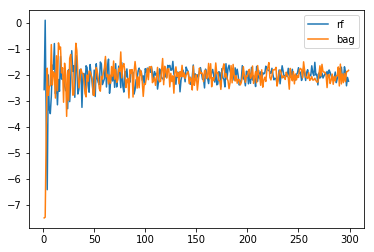

In [15]:
%matplotlib inline
plt.plot(test_error_rf, label='rf')
plt.plot(test_error_bag, label='bag')
plt.legend()
plt.show()


## RandomForest Imple by ourself

```python
class NotAsRandomForest:
  def __init__(self, n_estimators):
    self.B = n_estimators

  def fit(self, X, Y, M=None):
    N, D = X.shape
    if M is None:
      M = int(np.sqrt(D))

    self.models = []
    self.features = []
    for b in range(self.B):
      tree = DecisionTreeClassifier()

      # sample features
      features = np.random.choice(D, size=M, replace=False)

      # sample training samples
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      tree.fit(Xb[:, features], Yb)
      self.features.append(features)
      self.models.append(tree)

  def predict(self, X):
    N = len(X)
    P = np.zeros(N)
    for features, tree in zip(self.features, self.models):
      P += tree.predict(X[:, features])
    return np.round(P / self.B)

  def score(self, X, Y):
    P = self.predict(X)
    return np.mean(P == Y)
```

# Connecting to Deep Learning

- Random Forests are connected to deep learning in an interesting way
- not only we we randomly select training samples, we also randomly select features at each node spilit


## Dropout Regularization

- Drop nodes with probability 20~50%
- That's throwing away half the features

- Each node can be used or not used
- 2 states of being for each node
- if neural network has N nodes, then there are 2^N different possibilities


- Dropout emulates an ensemble of 2^N networks by randomly dropping nodes
- During training: Drop node with probability
- During prediction: Don't drop anything, multiply every layer by 1-p 
- allows you to make an ensemble without making an ensemble
- similar to random forest: randomly selecting which features to look at
- if you're doing batch training, the sub-network is also seeing a random subset of training samples also